In [ ]:
# %%

import torchvision
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

dataset_voc = torchvision.datasets.VOCSegmentation(
    "/data/pascal_voc/",
    year="2012",
    download=True,
    image_set="val",
)
print("number of images in the dataset:", len(dataset_voc))

Using downloaded and verified file: /data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /data/pascal_voc/VOCtrainval_11-May-2012.tar to /data/pascal_voc/
number of images in the dataset: 1449


In [ ]:
# %%

from einops import rearrange
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
import numpy as np


def feature_extractor(images, resolution=(448, 448), layer=11):
    if isinstance(images, list):
        assert isinstance(images[0], Image.Image), "Input must be a list of PIL images."
    else:
        assert isinstance(images, Image.Image), "Input must be a PIL image."
        images = [images]

    transform = transforms.Compose(
        [
            transforms.Resize(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

    # extract DINOv2 last layer features from the image
    class DiNOv2Feature(torch.nn.Module):
        def __init__(self, ver="dinov2_vitb14_reg", layer=11):
            super().__init__()
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", ver)
            self.dinov2.requires_grad_(False)
            self.dinov2.eval()
            self.dinov2 = self.dinov2.cuda()
            self.layer = layer

        def forward(self, x):
            out = self.dinov2.get_intermediate_layers(x, reshape=True, n=np.arange(12))[
                self.layer
            ]
            return out

    feat_extractor = DiNOv2Feature(layer=layer)

    feats = []
    for i, image in enumerate(images):
        torch_image = transform(image)
        feat = feat_extractor(torch_image.unsqueeze(0).cuda()).cpu()
        feat = feat.squeeze(0).permute(1, 2, 0)
        feats.append(feat)
    feats = torch.stack(feats).squeeze(0)
    return feats

In [ ]:
# %%

images = [dataset_voc[i][0] for i in range(20)]
feats1 = feature_extractor(images, resolution=(224, 224), layer=9)
num_nodes1 = np.prod(feats1.shape[:3])

feats2 = feature_extractor(images, resolution=(448, 448), layer=9)
num_nodes2 = np.prod(feats2.shape[:3])
mixed_feats = torch.cat(
    [feats1.reshape(-1, feats1.shape[-1]), feats2.reshape(-1, feats2.shape[-1])], dim=0
)
print("Mixed feature shape:", mixed_feats.shape)
print("224x224 feature shape:", feats1.shape, 'num_nodes:', num_nodes1)
print("448x448 feature shape:", feats2.shape, 'num_nodes:', num_nodes2)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Mixed feature shape: torch.Size([25600, 768])
224x224 feature shape: torch.Size([20, 16, 16, 768]) num_nodes: 5120
448x448 feature shape: torch.Size([20, 32, 32, 768]) num_nodes: 20480


In [ ]:
# %%

from ncut_pytorch import NCUT, rgb_from_tsne_3d

eigenvectors, eigenvalues = NCUT(
    num_eig=50, num_sample=30000, knn=10, affinity_focal_gamma=0.5, device="cuda:0"
).fit_transform(mixed_feats)

X_3d, rgb = rgb_from_tsne_3d(eigenvectors)

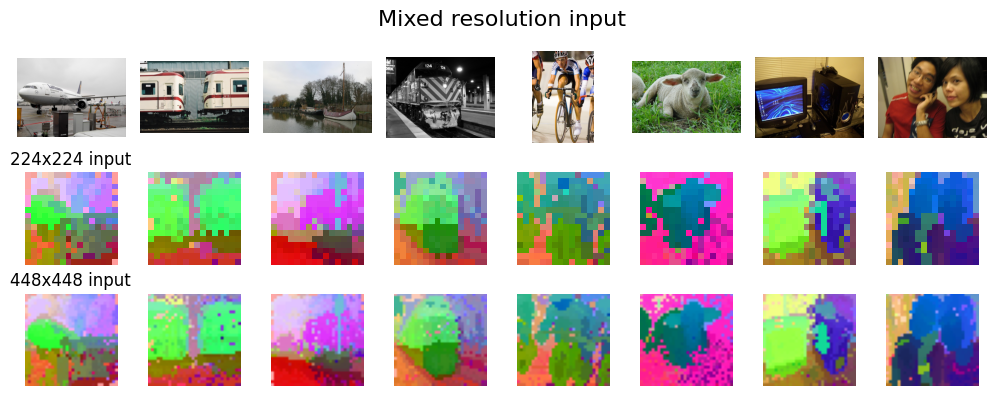

In [ ]:
# %%

import matplotlib.pyplot as plt

rgb1 = rgb[:num_nodes1].reshape(*feats1.shape[:3], 3)
rgb2 = rgb[num_nodes1:].reshape(*feats2.shape[:3], 3)
fig, axs = plt.subplots(3, 8, figsize=(10, 4))
for ax in axs.flatten():
    ax.axis("off")
for i in range(8):
    axs[0, i].imshow(images[i])
    axs[1, i].imshow(rgb1[i].cpu().numpy())
    axs[2, i].imshow(rgb2[i].cpu().numpy())
axs[1, 0].set_title("224x224 input")
axs[2, 0].set_title("448x448 input")
plt.suptitle("Mixed resolution input", fontsize=16)
plt.tight_layout()
plt.show()